In [3]:
#preprocessing
import nltk,sys
import numpy as np,pandas as pd
import matplotlib.pyplot as plt 
import nltk.data
from nltk.stem.porter import *
import os
import pandas as pd
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
import csv
from nltk.stem.wordnet import WordNetLemmatizer
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
import svm
from sklearn.svm import SVC
SVC_model = SVC()
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from symspellpy.symspellpy import SymSpell, Verbosity  # import the module
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
import emoji
from pprint import pprint

In [47]:
from nltk.tokenize import WordPunctTokenizer

In [4]:
dep = pd.read_csv("Twitter_data.csv", encoding= 'unicode_escape')
df = dep.copy()

In [3]:
df.head()

,srno,tweet,label
0,1,Today in Selfcare: beauty &amp; laughs Kung Fu...,0
1,2,I get to spend New Year's home again alone and...,1
2,3,"Depressed and lonely /: Stuck in a deep, never...",1
3,4,If this is your response to someone saying the...,0
4,5,Apparently you get a free pass just by mention...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31634 entries, 0 to 31633
Data columns (total 3 columns):
srno     31634 non-null int64
tweet    31634 non-null object
label    31634 non-null int64
dtypes: int64(2), object(1)
memory usage: 741.5+ KB


In [5]:
df.shape

(31634, 3)

In [6]:
df.describe()

,srno,label
count,31634.000000,31634.000000
mean,15817.500000,0.414459
std,9132.093544,0.492636
min,1.000000,0.000000
25%,7909.250000,0.000000
50%,15817.500000,0.000000
75%,23725.750000,1.000000
max,31634.000000,1.000000


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
srno,31634.0,15817.500000,9132.093544,1.0,7909.25,15817.5,23725.75,31634.0
label,31634.0,0.414459,0.492636,0.0,0.00,0.0,1.00,1.0


In [8]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,srno,tweet,label
0,1,Today in Selfcare: beauty &amp; laughs Kung Fu...,0
1,2,I get to spend New Year's home again alone and...,1
2,3,"Depressed and lonely /: Stuck in a deep, never...",1
3,4,If this is your response to someone saying the...,0
4,5,Apparently you get a free pass just by mention...,0
5,6,When you will never again give birth to violen...,0
6,7,Learning to pretend to have a good time had be...,1
7,8,When you go out and try to be a part of life &...,0
8,9,So far he stop texting me after I said somethi...,1
9,10,Portable Transparent Tobacco Rolling Machine ...,0


In [9]:
df.isna().sum()

srno     0
tweet    0
label    0
dtype: int64

### Pre Processing Tweets

In [5]:
regexp = {"RT": "^RT", "MT": r"^MT", "ALNUM": r"(@[a-zA-Z0-9_]+)",
              "HASHTAG": r"(#[\w\d]+)", "URL": r"([https://|http://]?[a-zA-Z\d\/]+[\.]+[a-zA-Z\d\/\.]+)",
              "SPACES": r"\s+"}
regexp = dict((key, re.compile(value)) for key, value in regexp.items())


class Emoticons:
    POSITIVE = [ ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3',"*O", "*-*", "*O*", "*o*", "* *",":P", ":D", ":d", ":p",";P", ";D", ";d", ";p",
    ":-)", ";-)", ":=)", ";=)",":<)", ":>)", ";>)", ";=)","=}", ":)", "(:;)","(;", ":}", "{:", ";}","{;:]","[;", ":')", ";')", ":-3","{;", ":]",
    ";-3", ":-x", ";-x", ":-X",";-X", ":-}", ";-=}", ":-]",";-]", ":-.)","^_^", "^-^"]

    NEGATIVE = [ ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(',":(", ";(", ":'(",
                "=(", "={", "):", ");",
                ")':", ")';", ")=", "}=",
                ";-{{", ";-{", ":-{{", ":-{",
                ":-(", ";-(",
                ":,)", ":'{",
                "[:", ";]"
                ]
#filter emoticon
def emoticon_tweet(tweet):
    emoji = list()
    sc = 0
    for tok in re.split(regexp["SPACES"], tweet.strip()):
        if tok in Emoticons.POSITIVE:
            sc=0
            emoji.append(str(sc))
            continue
        if tok in Emoticons.NEGATIVE:
            sc=1
            emoji.append(str(sc))
            #emoji.append(tok)
    return ' '.join(emoji)
df['tweet_emo'] = df['tweet'].apply(emoticon_tweet)

In [11]:
df.head(10)

,srno,tweet,label,tweet_emo
0,1,Today in Selfcare: beauty &amp; laughs Kung Fu...,0,
1,2,I get to spend New Year's home again alone and...,1,
2,3,"Depressed and lonely /: Stuck in a deep, never...",1,1
3,4,If this is your response to someone saying the...,0,
4,5,Apparently you get a free pass just by mention...,0,
5,6,When you will never again give birth to violen...,0,
6,7,Learning to pretend to have a good time had be...,1,
7,8,When you go out and try to be a part of life &...,0,
8,9,So far he stop texting me after I said somethi...,1,
9,10,Portable Transparent Tobacco Rolling Machine ...,0,


In [12]:
df.isna().sum()

srno         0
tweet        0
label        0
tweet_emo    0
dtype: int64

In [6]:
#FIND USER MENTION
def mention_tweet(tweet):
    r=re.findall("@([a-zA-Z0-9]{1,15})",tweet )
    return ' '.join(r)
df['tweet_men'] = df['tweet'].apply(mention_tweet)


In [14]:
df.head(10)

,srno,tweet,label,tweet_emo,tweet_men
0,1,Today in Selfcare: beauty &amp; laughs Kung Fu...,0,,
1,2,I get to spend New Year's home again alone and...,1,,
2,3,"Depressed and lonely /: Stuck in a deep, never...",1,1,
3,4,If this is your response to someone saying the...,0,,
4,5,Apparently you get a free pass just by mention...,0,,
5,6,When you will never again give birth to violen...,0,,
6,7,Learning to pretend to have a good time had be...,1,,
7,8,When you go out and try to be a part of life &...,0,,
8,9,So far he stop texting me after I said somethi...,1,,
9,10,Portable Transparent Tobacco Rolling Machine ...,0,,


In [15]:
df.to_csv("11.csv")

In [7]:
#FIND hashtag
def hashtag_tweet(tweet):
    r=re.findall("#([a-zA-Z0-9]{1,20})",tweet )
    return ' '.join(r)
df['tweet_hash'] = df['tweet'].apply(hashtag_tweet)

In [17]:
df.head(10)

,srno,tweet,label,tweet_emo,tweet_men,tweet_hash
0,1,Today in Selfcare: beauty &amp; laughs Kung Fu...,0,,,Wellness joy laughter selfcare therapist phila...
1,2,I get to spend New Year's home again alone and...,1,,,
2,3,"Depressed and lonely /: Stuck in a deep, never...",1,1,,
3,4,If this is your response to someone saying the...,0,,,
4,5,Apparently you get a free pass just by mention...,0,,,
5,6,When you will never again give birth to violen...,0,,,
6,7,Learning to pretend to have a good time had be...,1,,,
7,8,When you go out and try to be a part of life &...,0,,,
8,9,So far he stop texting me after I said somethi...,1,,,
9,10,Portable Transparent Tobacco Rolling Machine ...,0,,,


In [8]:
#filter capital letters
def capital_tweet(tweet):
    capitalized_words = r"\b[A-Z][A-Z]+\b"
    r=re.findall(capitalized_words,tweet)
    return ' '.join(r)
df['tweet_cap'] = df['tweet'].apply(capital_tweet)

In [19]:
df.head(10)

,srno,tweet,label,tweet_emo,tweet_men,tweet_hash,tweet_cap
0,1,Today in Selfcare: beauty &amp; laughs Kung Fu...,0,,,Wellness joy laughter selfcare therapist phila...,
1,2,I get to spend New Year's home again alone and...,1,,,,
2,3,"Depressed and lonely /: Stuck in a deep, never...",1,1,,,
3,4,If this is your response to someone saying the...,0,,,,
4,5,Apparently you get a free pass just by mention...,0,,,,
5,6,When you will never again give birth to violen...,0,,,,
6,7,Learning to pretend to have a good time had be...,1,,,,
7,8,When you go out and try to be a part of life &...,0,,,,
8,9,So far he stop texting me after I said somethi...,1,,,,
9,10,Portable Transparent Tobacco Rolling Machine ...,0,,,,


In [9]:
#count no of repetative Q
def q_tweet(tweet):
    cnt_q=(len(re.findall('\?{2,10}', tweet)))
    return cnt_q
df['tweet_q'] = df['tweet'].apply(q_tweet)

In [10]:
#count no of repetative !
def ex_tweet(tweet):
    cnt_ex=(len(re.findall('\!{2,10}', tweet)))
    return cnt_ex
df['tweet_ex'] = df['tweet'].apply(ex_tweet)

In [11]:
def clean_tweet(tweet):
    clean_tweet = []
    #print("1 :",tweet)    
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
   # print("2 :",tweet) 
    #remove email
    tweet=re.sub("[\w]+@[\w]+\.[a-z]{3}", "", tweet)
   # print("3 :",tweet) 
    #remove url
    #tweet=re.sub(regexp["URL"]," ",tweet )
    tweet=re.sub('http\S+\s*',"",tweet)
   # print("4 :",tweet) 
    #remove mentions
    tweet=re.sub("@([a-zA-Z0-9_]{1,20})","", tweet)
  #  print("5 :",tweet) 
    #remove hashtag
    tweet=re.sub("#\S+","", tweet)
  #  print("6 :",tweet) 
    #remove punctuation other than ? and !
    tweet=re.sub('[%s]' % re.escape("%&*\"-./:;<=>[\]^_`{|}~?!"), '', tweet)
  #  print("7 :",tweet) 
    #remove digits
    tweet=re.sub("[0-9]","", tweet)
  #  print("8 :",tweet) 
    tok = WordPunctTokenizer()
    # Tokenize and join to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(tweet) if len(x) > 1]
            #return (" ".join(words)).strip()

    # Tokenize and join to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(tweet) if len(x) > 1]
    #remove stopword
    stop_words = set(stopwords.words('english'))
    stopwords_add=("'re'","(","'rt","n't","amp","I","i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "would", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz")
    stopword1=set(stopwords_add)
    stopword_new=stop_words.union(stopword1)
    word_tokens = nltk.word_tokenize(tweet) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    tweet = ' '.join(filtered_sentence)

    #stemming words
    tweet = PorterStemmer().stem(tweet)
    clean_tweet.append(tweet)
    return clean_tweet

df['tweet_cln'] = df['tweet'].apply(clean_tweet)



In [12]:
df['tweet_cln'] = [','.join(map(str, l)) for l in df['tweet_cln']]

In [70]:
df.head(10)

,srno,tweet,label,tweet_emo,tweet_men,tweet_hash,tweet_cap,tweet_q,tweet_ex,tweet_cln,tweet_low,tweet_lem,sentiment
0,1,Today in Selfcare: beauty &amp; laughs Kung Fu...,0,,,Wellness joy laughter selfcare therapist phila...,,0,0,today selfcare beauty amp laughs kung fu panda,today selfcare beauty amp laughs kung fu panda,today selfcare beauty amp laugh kung fu panda,0.300000
1,2,I get to spend New Year's home again alone and...,1,,,,,1,0,i get spend new year 's home alone lon,i get spend new year 's home alone lonely ? ? ?,i get spend new year 's home alone lonely ? ? ?,0.018182
2,3,"Depressed and lonely /: Stuck in a deep, never...",1,1,,,,0,0,"depressed lonely stuck deep , never ending hole (","depressed lonely stuck deep , never ending hole (","depress lonely stuck deep , never end hole (",-0.055556
3,4,If this is your response to someone saying the...,0,,,,,0,0,"if response someone saying 're dealing , 're t...","if response someone saying 're dealing , 're t...","if response someone say 're deal , 're terribl...",-1.000000
4,5,Apparently you get a free pass just by mention...,0,,,,,1,1,apparently get free pass mentioning where i fr...,apparently get free pass mentioning where i fr...,apparently get free pas mention where i free b...,0.400000
5,6,When you will never again give birth to violen...,0,,,,,0,0,when never give birth violent men pictwitterco...,when never give birth violent men pictwitterco...,when never give birth violent men pictwitterco...,-0.800000
6,7,Learning to pretend to have a good time had be...,1,,,,,0,0,learning pretend good time become natural skil...,learning pretend good time become natural skil...,learn pretend good time become natural skill i...,0.400000
7,8,When you go out and try to be a part of life &...,0,,,,,0,0,when go try part life end feeling like less pa...,when go try part life end feeling like less pa...,when go try part life end feel like less part ...,0.000000
8,9,So far he stop texting me after I said somethi...,1,,,,,0,0,so far stop texting i said something hopefully...,so far stop texting i said something hopefully...,so far stop texting i say something hopefully ...,0.000000
9,10,Portable Transparent Tobacco Rolling Machine ...,0,,,,,0,0,portable transparent tobacco rolling machine p...,portable transparent tobacco rolling machine p...,portable transparent tobacco roll machine pict...,0.000000


In [13]:
#to_lowercase
df['tweet_low'] = df['tweet_cln'].apply(lambda x: " ".join(x.lower() for x in x.split()))


In [14]:
#lemmatization
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()
def Lemma_tweet(tweet):
    lmtzr = WordNetLemmatizer()
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
    # tokenize the sentence and find the POS tag for each token
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(tweet)) 
    # we use our own pos_tagger function to make things simpler to understand.
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    #print(wordnet_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
        # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
        # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

df['tweet_lem'] = df['tweet_low'].apply(Lemma_tweet)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\PRANALI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [66]:
df.head(10)


,srno,tweet,label,tweet_emo,tweet_men,tweet_hash,tweet_cap,tweet_q,tweet_ex,tweet_cln,tweet_low,tweet_lem,sentiment
0,1,Today in Selfcare: beauty &amp; laughs Kung Fu...,0,,,Wellness joy laughter selfcare therapist phila...,,0,0,today selfcare beauty amp laughs kung fu panda,today selfcare beauty amp laughs kung fu panda,today selfcare beauty amp laugh kung fu panda,0.300000
1,2,I get to spend New Year's home again alone and...,1,,,,,1,0,i get spend new year 's home alone lonely ? ? ?,i get spend new year 's home alone lonely ? ? ?,i get spend new year 's home alone lonely ? ? ?,0.018182
2,3,"Depressed and lonely /: Stuck in a deep, never...",1,1,,,,0,0,"depressed lonely stuck deep , never ending hole (","depressed lonely stuck deep , never ending hole (","depress lonely stuck deep , never end hole (",-0.055556
3,4,If this is your response to someone saying the...,0,,,,,0,0,"if response someone saying 're dealing , 're t...","if response someone saying 're dealing , 're t...","if response someone say 're deal , 're terribl...",-1.000000
4,5,Apparently you get a free pass just by mention...,0,,,,,1,1,apparently get free pass mentioning where i fr...,apparently get free pass mentioning where i fr...,apparently get free pas mention where i free b...,0.400000
5,6,When you will never again give birth to violen...,0,,,,,0,0,when never give birth violent men pictwitterco...,when never give birth violent men pictwitterco...,when never give birth violent men pictwitterco...,-0.800000
6,7,Learning to pretend to have a good time had be...,1,,,,,0,0,learning pretend good time become natural skil...,learning pretend good time become natural skil...,learn pretend good time become natural skill i...,0.400000
7,8,When you go out and try to be a part of life &...,0,,,,,0,0,when go try part life end feeling like less pa...,when go try part life end feeling like less pa...,when go try part life end feel like less part ...,0.000000
8,9,So far he stop texting me after I said somethi...,1,,,,,0,0,so far stop texting i said something hopefully...,so far stop texting i said something hopefully...,so far stop texting i say something hopefully ...,0.000000
9,10,Portable Transparent Tobacco Rolling Machine ...,0,,,,,0,0,portable transparent tobacco rolling machine p...,portable transparent tobacco rolling machine p...,portable transparent tobacco roll machine pict...,0.000000


In [15]:
#Textblob sentiment
df['sentiment'] = df['tweet_lem'].apply(lambda x: TextBlob(x).sentiment[0] )

<Figure size 2880x1800 with 0 Axes>

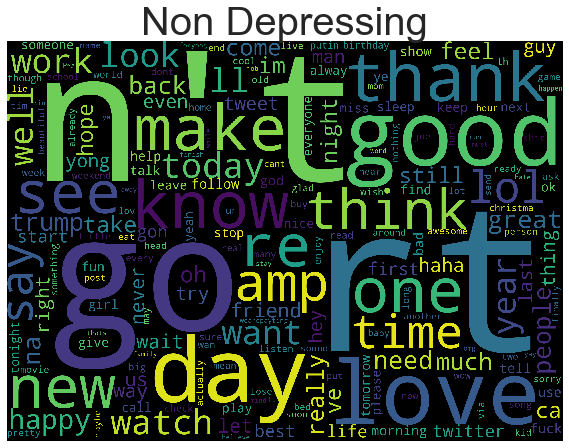

<Figure size 2880x1800 with 0 Axes>

In [16]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

# traffic
subset = df[df.label==0]
text = subset.tweet_lem.values
cloud_traffic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(3, 3, 1)
plt.axis('off')
plt.title("Non Depressing",fontsize=40)
plt.imshow(cloud_traffic)
plt.figure(figsize=(40,25))



<Figure size 2880x1800 with 0 Axes>

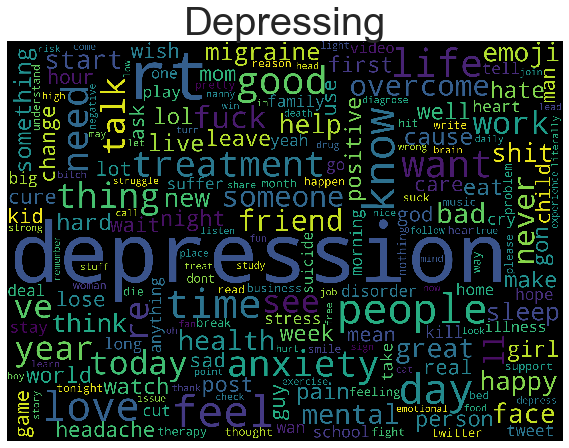

<Figure size 2880x1800 with 0 Axes>

In [29]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

# traffic
subset = df[df.label==1]
text = subset.tweet_lem.values
cloud_traffic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(3, 3, 1)
plt.axis('off')
plt.title("Depressing",fontsize=40)
plt.imshow(cloud_traffic)
plt.figure(figsize=(40,25))

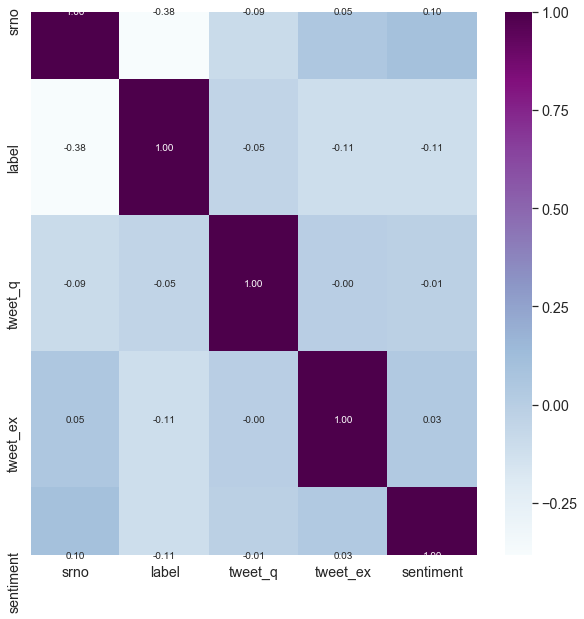

In [30]:
corr_= df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_, annot=True, fmt = ".2f", cmap = "BuPu")

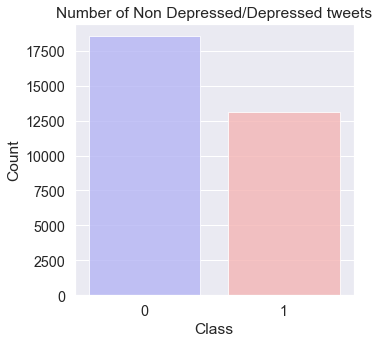

In [31]:
count = df['label'].value_counts()
sns.set_context(font_scale=1.5)
plt.figure(figsize=(5,5))
sns.barplot(count.index, count.values, alpha=0.8, palette="bwr")
plt.ylabel('Count')
plt.xlabel('Class')
plt.title('Number of Non Depressed/Depressed tweets')
#plt.savefig("count.jpeg", format='jpeg', dpi=300)
plt.show()

## With CLeaned Tweet

In [17]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet_cln"],df["label"], test_size = 0.2, random_state = 42)

In [18]:
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [19]:
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [20]:
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

# TFIDF

In [36]:
SVC_model.fit(x_train_tfidf, y_train)

SVC()

In [37]:
SVC_prediction = SVC_model.predict(x_test_tfidf)
print(accuracy_score(SVC_prediction, y_test))
print(confusion_matrix(SVC_prediction, y_test))

0.7643432906590801
[[3334 1101]
 [ 390 1502]]


In [38]:
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(x_train_tfidf, y_train)
KNN_prediction = KNN_model.predict(x_test_tfidf)
print(accuracy_score(KNN_prediction, y_test))
print(classification_report(KNN_prediction, y_test))

0.5920657499604868
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      3641
           1       0.52      0.50      0.51      2686

    accuracy                           0.59      6327
   macro avg       0.58      0.58      0.58      6327
weighted avg       0.59      0.59      0.59      6327



In [39]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model.fit(x_train_tfidf,y_train)
predictions = model.predict(x_test_tfidf)
print(accuracy_score(predictions, y_test))
print(classification_report(predictions, y_test))

0.7479058005373795
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      4247
           1       0.59      0.74      0.66      2080

    accuracy                           0.75      6327
   macro avg       0.72      0.75      0.73      6327
weighted avg       0.77      0.75      0.75      6327



In [40]:
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression()
logreg_clf.fit(x_train_tfidf,y_train)
log_prec = logreg_clf.predict(x_test_tfidf)
print(accuracy_score(log_prec, y_test))
print(confusion_matrix(log_prec, y_test))
print(classification_report(log_prec, y_test))

0.7610241820768137
[[3335 1123]
 [ 389 1480]]
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      4458
           1       0.57      0.79      0.66      1869

    accuracy                           0.76      6327
   macro avg       0.73      0.77      0.74      6327
weighted avg       0.80      0.76      0.77      6327



# CountVec

In [73]:
SVC_model.fit(x_train_counts, y_train)
SVC_prediction = SVC_model.predict(x_test_counts)
print(accuracy_score(SVC_prediction, y_test))
print(confusion_matrix(SVC_prediction, y_test))

0.8372056266793109
[[3597  903]
 [ 127 1700]]


In [74]:
KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(x_train_counts, y_train)
KNN_prediction = KNN_model.predict(x_test_counts)
print(accuracy_score(KNN_prediction, y_test))
print(classification_report(KNN_prediction, y_test))

0.6941678520625889
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      3629
           1       0.65      0.62      0.63      2698

    accuracy                           0.69      6327
   macro avg       0.69      0.69      0.69      6327
weighted avg       0.69      0.69      0.69      6327



In [75]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=200)
model.fit(x_train_counts,y_train)
predictions = model.predict(x_test_counts)
print(accuracy_score(predictions, y_test))
print(classification_report(predictions, y_test))

0.8413149992097361
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      4026
           1       0.75      0.85      0.80      2301

    accuracy                           0.84      6327
   macro avg       0.83      0.84      0.83      6327
weighted avg       0.85      0.84      0.84      6327



In [21]:
from sklearn.linear_model import LogisticRegression
logreg_clf = LogisticRegression()
logreg_clf.fit(x_train_tfidf,y_train)
log_prec = logreg_clf.predict(x_test_tfidf)
print(accuracy_score(log_prec, y_test))
print(confusion_matrix(log_prec, y_test))
print(classification_report(log_prec, y_test))

0.7539118065433855
[[3320 1153]
 [ 404 1450]]
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      4473
           1       0.56      0.78      0.65      1854

    accuracy                           0.75      6327
   macro avg       0.72      0.76      0.73      6327
weighted avg       0.79      0.75      0.76      6327



## With Noisy tweets


In [41]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet"],df["label"], test_size = 0.2, random_state = 42)
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)

logreg_clf.fit(x_train_tfidf,y_train)
log_prec = logreg_clf.predict(x_test_tfidf)
print(accuracy_score(log_prec, y_test))
print(confusion_matrix(log_prec, y_test))
print(classification_report(log_prec, y_test))

0.8397344713134187
[[3503  793]
 [ 221 1810]]
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      4296
           1       0.70      0.89      0.78      2031

    accuracy                           0.84      6327
   macro avg       0.82      0.85      0.83      6327
weighted avg       0.86      0.84      0.84      6327



## Unigram-tfidf

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet_cln"],df["label"], test_size = 0.2, random_state = 42)
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), max_features=5000)

In [23]:
tfidf_vect_ngram.fit(df['tweet_cln'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(x_test)

In [24]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.7577050734945472


# unigram-count

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet_cln"],df["label"], test_size = 0.2, random_state = 42)
count_ngram = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), max_features=5000)

In [27]:
count_ngram.fit(df['tweet_cln'])
xtrain_count_ngram =  count_ngram.transform(x_train)
xtest_count_ngram =  count_ngram.transform(x_test)

In [29]:
from sklearn.ensemble import RandomForestClassifier
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier(n_estimators=200), xtrain_count_ngram, y_train, xtest_count_ngram)
print ("RF, N-Gram Vectors: ", accuracy)

RF, N-Gram Vectors:  0.7314683104156788


## Bigram

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet_cln"],df["label"], test_size = 0.2, random_state = 42)
count_ngram = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,2), max_features=5000)
count_ngram.fit(df['tweet_cln'])
xtrain_count_ngram =  count_ngram.transform(x_train)
xtest_count_ngram =  count_ngram.transform(x_test)

from sklearn.ensemble import RandomForestClassifier
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier(n_estimators=200), xtrain_count_ngram, y_train, xtest_count_ngram)
print ("RF, N-Gram Vectors: ", accuracy)

RF, N-Gram Vectors:  0.6797850482061009


## with tweets -unigram

In [32]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet"],df["label"], test_size = 0.2, random_state = 42)
count_ngram = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1), max_features=5000)
count_ngram.fit(df['tweet'])
xtrain_count_ngram =  count_ngram.transform(x_train)
xtest_count_ngram =  count_ngram.transform(x_test)

from sklearn.ensemble import RandomForestClassifier
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(logreg_clf, xtrain_count_ngram, y_train, xtest_count_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

LR, N-Gram Vectors:  0.848585427532796


c:\users\pranali\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


 ## tweet-bigram

In [33]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet"],df["label"], test_size = 0.2, random_state = 42)
count_ngram = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,2), max_features=5000)
count_ngram.fit(df['tweet'])
xtrain_count_ngram =  count_ngram.transform(x_train)
xtest_count_ngram =  count_ngram.transform(x_test)

from sklearn.ensemble import RandomForestClassifier
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(logreg_clf, xtrain_count_ngram, y_train, xtest_count_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

LR, N-Gram Vectors:  0.7659238185553975


c:\users\pranali\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Trigram

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df["tweet"],df["label"], test_size = 0.2, random_state = 42)
count_ngram = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(3,3), max_features=5000)
count_ngram.fit(df['tweet'])
xtrain_count_ngram =  count_ngram.transform(x_train)
xtest_count_ngram =  count_ngram.transform(x_test)

from sklearn.ensemble import RandomForestClassifier
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, y_test)

# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(logreg_clf, xtrain_count_ngram, y_train, xtest_count_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

LR, N-Gram Vectors:  0.7365259996838944


c:\users\pranali\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
